# Aim: To see the effect of the size of the Nebula radius on red fraction

In [1]:
# importing all necessary library

from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

### $\textbf{Importing data of 1M sources for plotting HR Diagram}$

In [2]:
# importing csv file of 1m sources containing Gaia data for plotting HR diagram
filename = '1M.csv'
df1 = pd.read_csv(filename)

# filtering data on the basis of parallax error so that we can get better observed sources
df = df1[df1['parallax_error']< 0.1]
df = df.reset_index(drop=True)


gk_1m = df["phot_g_mean_mag"] - df["ks_m"]
mg = df["mg"]

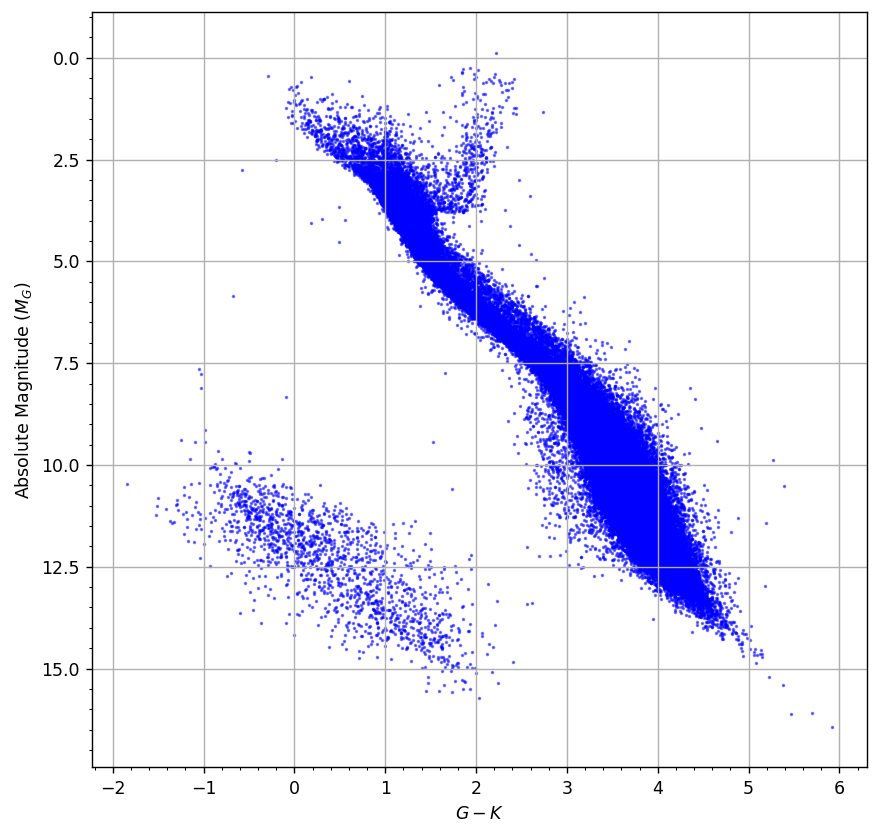

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 125, figsize = (8, 8))
ax.set_xlabel(r"$G - K$")
ax.set_ylabel(r"Absolute Magnitude ($M_G$)")
ax.scatter(gk_1m, mg, s = 1, alpha= 0.5, c = 'blue')
ax.minorticks_on()
ax.grid(True)
ax.set_ylim(max(mg) + 1, min(mg) - 1)
plt.show()

### $\textbf{Boundary equation}$

In [4]:
# Defining the equation of straight line for the boundries

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------


def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)df_herb5 = df_herb.drop(columns=["plx", "recno"])
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

### $\textbf{Plotting those boundary line at HR Diagram}$

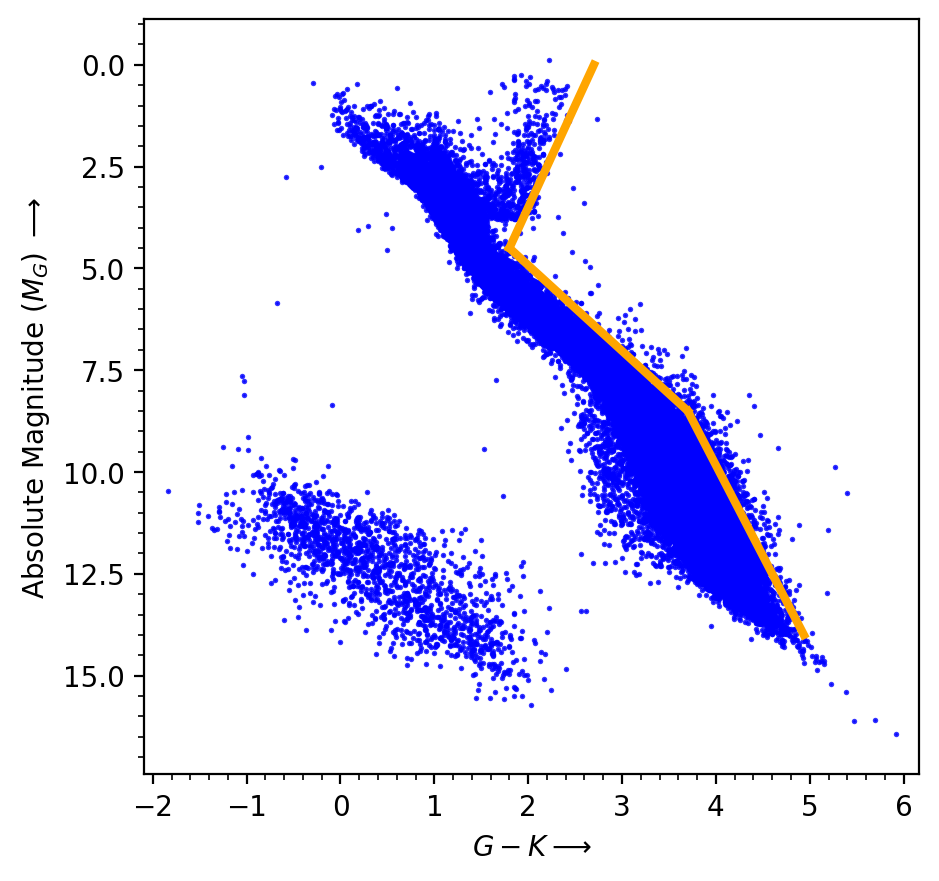

In [43]:
# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(0, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 14.0, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5, 5), dpi = 200)
ax.set_xlabel(r"$G - K \longrightarrow$")
ax.set_ylabel(r"Absolute Magnitude ($M_G$) $\longrightarrow$", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(gk_1m, mg, s = 0.9, alpha = 0.8, c = 'blue')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange', linewidth = 3)
ax.plot(equation2(y_values2), y_values2,  color = 'orange', linewidth = 3)
ax.plot(equation3(y_values3), y_values3, color = 'orange', linewidth = 3)

ax.minorticks_on()
# ax.grid(True)
ax.set_ylim(max(mg)+1, min(mg)-1)
ax.set_xlim(min(gk_1m)-0.25, max(gk_1m)+0.25)
plt.show()

### $ \bm{\mathfrak{Extracting ~~data~~ from ~~the ~~gaia ~~table ~~around~~ a ~~star~~ having~~ ra~~ and ~~dec}}$

In [6]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query = """SELECT TOP {}""".format(query_size) + """
        g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, d3.r_med_photogeo, d3.r_lo_photogeo, d3.r_hi_photogeo,(d3.r_hi_photogeo - d3.r_lo_photogeo)/(2 * d3.r_med_photogeo) AS dist_frac, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr2.gaia_source as g, gaiadr2.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr2.tmass_best_neighbour as t, tmass_original_valid as tt, external.gaiaedr3_distance AS d3
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.tmass_oid = tt.tmass_oid)) AND (g.source_id = d3.source_id)
        """

    job = Gaia.launch_job(query)
    result = job.get_results()

    return result

### $\textbf{Counting function}$

In [7]:
# Defining a function which will count red object
# just we need to pass list of object(stars) with G-K as X- coordinate and Absolute Magnitude(Mv) as Y-coordinate 

def counting_fun(her_mg, her_gk):

    count_red = 0

    for i in range(len(her_mg)):

        if her_mg[i] <= 4.5:
            if her_gk[i] >= equation1(her_mg[i]):
                count_red = count_red + 1
        
        if 4.5 < her_mg[i] and her_mg[i] <= 8.5:
            if her_gk[i] >= equation2(her_mg[i]):
                count_red = count_red + 1

        if 8.5 < her_mg[i]:
            if her_gk[i] >= equation3(her_mg[i]):
                count_red = count_red + 1


    return count_red

### $\textbf{Importing 20 Random and 20 Herbig Ae/Be Stars}$

In [8]:
# Random star

rnd_star20 = pd.read_csv("rnd_star20.csv")
rnd_star20 = rnd_star20.sort_values(by="r_med_photogeo")
rnd_star20 = rnd_star20.reset_index(drop= True)
# herbig Ae/Be  star

herbig_list = pd.read_csv("Herbig20.csv")
herbig_20 = herbig_list[["Name", "RAICRS", "DEICRS", "Dist"]]
herbig_20 = herbig_20.sort_values(by = 'Dist') 
herbig_20 = herbig_20.reset_index(drop=True)

In [9]:
rnd_star20

,source_id,ra,dec,parallax,parallax_error,phot_g_mean_mag,r_med_geo,r_med_photogeo
0,4200915277519116928,289.349216,-9.702235,2.474588,0.247459,18.542698,401.68665,427.10970
1,717208067544676736,130.988664,34.529991,2.198941,0.219894,17.969261,477.89066,487.06802
2,4082907546369920128,289.018242,-20.506235,1.025029,0.102503,16.242178,959.35680,946.50010
3,3115770487149358336,104.615488,2.601685,0.841241,0.084124,16.782425,1087.39450,1049.19200
4,6064263444233418624,205.970705,-56.124049,0.689494,0.068949,16.481983,1274.97550,1302.96060
5,5786818418133769600,218.438884,-76.535295,0.709305,0.070930,17.090054,1283.99340,1333.41200
6,2072876119015206272,296.086160,37.976531,0.662385,0.066239,17.032260,1444.49790,1430.29960
7,5880671802993674496,222.109197,-58.008760,0.729744,0.072974,16.984085,1461.18700,1445.18410
8,6053305195978753408,184.533565,-64.331466,0.663882,0.066388,16.908943,1486.67410,1574.93690
9,5927385585287154944,251.762500,-58.115117,0.617804,0.061780,16.161259,1629.06820,1616.18260


In [10]:
herbig_20

,Name,RAICRS,DEICRS,Dist
0,AK Sco,253.686667,-36.888611,140.6
1,AB Aur,73.941250,30.551111,162.9
2,CQ Tau,83.993750,24.748333,163.1
3,BD+30 549,52.332500,31.415833,295.4
4,BH Cep,330.428750,69.743333,335.1
5,BO Cep,334.225417,70.062500,374.5
6,GSC 8143-1225,119.798333,-50.379722,386.3
7,BF Ori,84.305417,-6.583611,388.8
8,CO Ori,81.909583,11.427500,404.0
9,GSC 8581-2002,131.098333,-59.949444,557.6


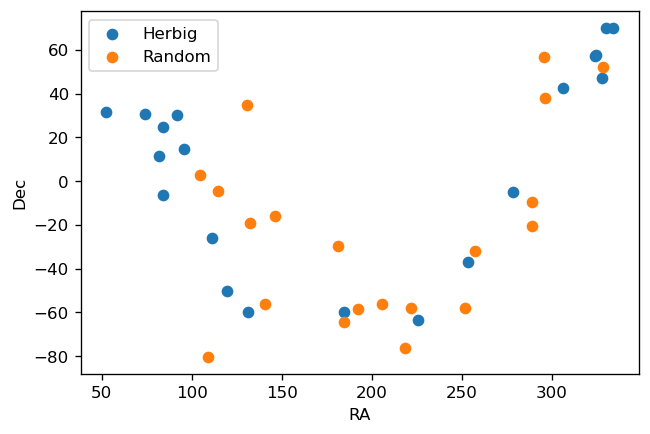

In [11]:
plt.figure(dpi = 120)
plt.scatter(herbig_20.RAICRS, herbig_20.DEICRS, label = 'Herbig')
plt.scatter(rnd_star20.ra, rnd_star20.dec, label = 'Random')
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

### $\textbf{Plotting in galactic coordinate}$

In [12]:
one_coord = SkyCoord(df.ra, df.dec, unit = (u.deg, u.deg))
herb_coord= SkyCoord(herbig_20.RAICRS, herbig_20.DEICRS, unit = (u.deg, u.deg))
rand_coord = SkyCoord(rnd_star20.ra, rnd_star20.dec, unit = (u.deg, u.deg))

# Converting to galactic coordinate in degrees

one_gal = one_coord.transform_to('galactic')
herb_gal = herb_coord.transform_to('galactic')
rand_gal = rand_coord.transform_to('galactic')


l_one = one_gal.l.radian
l_one[l_one > np.pi] -= 2.0*np.pi
b_one = one_gal.b.radian


l_herb = herb_gal.l.radian
l_herb[l_herb > np.pi] -= 2.0*np.pi
b_herb = herb_gal.b.radian


l_rand = rand_gal.l.radian
l_rand[l_rand > np.pi] -= 2.0*np.pi
b_rand = rand_gal.b.radian



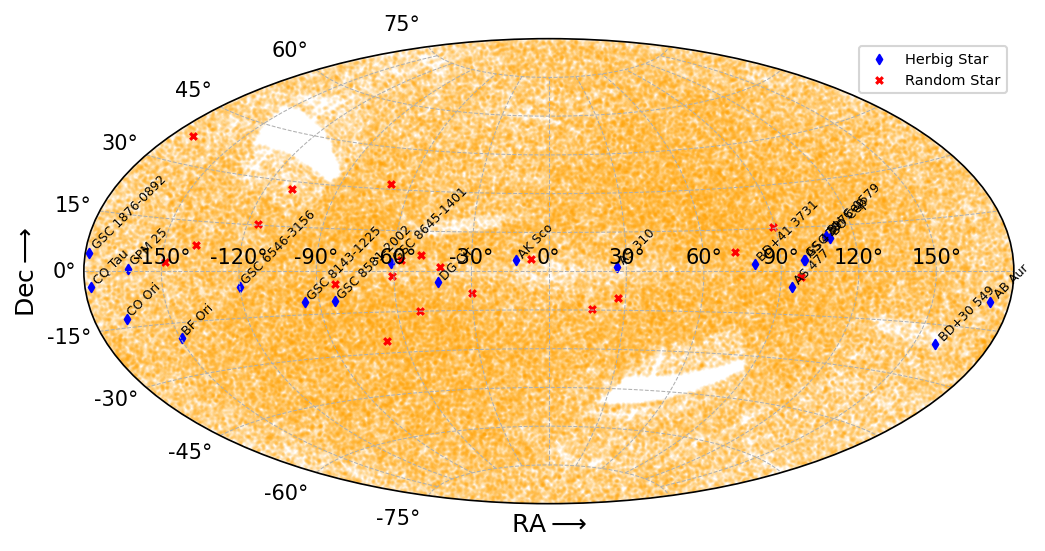

In [13]:
fig = plt.figure(figsize = [8, 5], dpi = 150)
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
ax.scatter(l_one, b_one, s = 1, color = 'orange', alpha = 0.1 )
ax.scatter(l_herb, b_herb, s = 10, color ='blue', marker = 'd', label = 'Herbig Star')
ax.scatter(l_rand, b_rand, s = 10, color = 'red', marker = "x", label = 'Random Star')
for i in range(len(l_herb)):
    ax.text(l_herb[i], b_herb[i]+ 0.02, '{}'.format(herbig_20.Name[i]), fontsize = 6, rotation = 45)
ax.legend(fontsize = 7)
ax.minorticks_on()
ax.grid(True, linewidth = 0.5, linestyle = '--')
ax.set_xlabel(r'$\mathrm{RA}\longrightarrow$')
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel(r'$\mathrm{Dec}\longrightarrow$')
ax.yaxis.label.set_fontsize(12)
# plt.savefig('posi.pdf', dpi = 500)
plt.show()


### $\textbf{Defining a function for calculating arcminute for a star}$

Assuming "Orion Nebula" as base distance = 412 pc and radius = 12 ly = 3.679 pc, this leads to angular size = 30.7 arcminute.

Our search radius = 6.0 arcminute

In [14]:
def get_arc_min(dist_star_pc):
    theta_ini = 6.0 # In arcminute
    
    dist_ini = 412   # In parsec
    theta_star = (dist_ini * theta_ini)/dist_star_pc

    return theta_star 

### Plotting ra vs Distance of star


In [15]:
herbig_20

,Name,RAICRS,DEICRS,Dist
0,AK Sco,253.686667,-36.888611,140.6
1,AB Aur,73.941250,30.551111,162.9
2,CQ Tau,83.993750,24.748333,163.1
3,BD+30 549,52.332500,31.415833,295.4
4,BH Cep,330.428750,69.743333,335.1
5,BO Cep,334.225417,70.062500,374.5
6,GSC 8143-1225,119.798333,-50.379722,386.3
7,BF Ori,84.305417,-6.583611,388.8
8,CO Ori,81.909583,11.427500,404.0
9,GSC 8581-2002,131.098333,-59.949444,557.6


6.118811881188119 1.8538906204533931


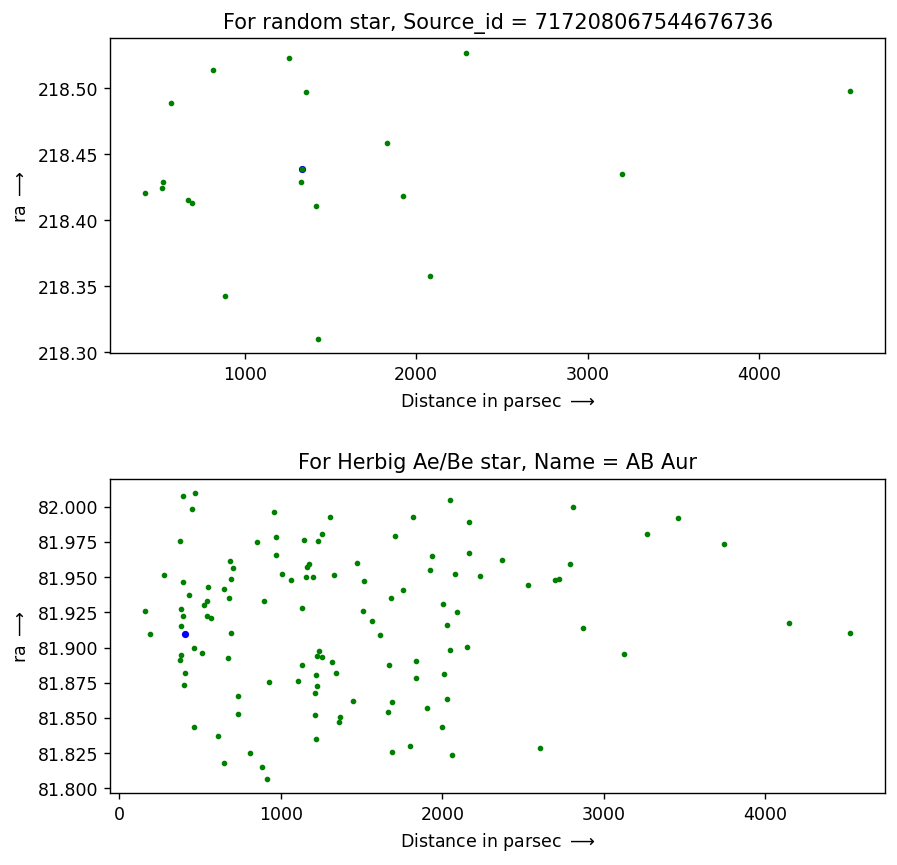

In [16]:


rad_star = get_arc_min(rnd_star20["r_med_photogeo"][5])
res_star = get_gaia_result(10000, rnd_star20["ra"][5], rnd_star20["dec"][5], rad_star/60.0)
rest_star = res_star[res_star["dist_frac"] < 0.2]

rad_her = get_arc_min(herbig_20["Dist"][8])
print(rad_her, rad_star)
res_her = get_gaia_result(10000, herbig_20["RAICRS"][8], herbig_20["DEICRS"][8], rad_her/60.0)
rest_her = res_her[res_her["dist_frac"] < 0.2]


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi = 125, figsize = (8,8))
#ax1.scatter(res_star["r_med_photogeo"], res_star["ra"], c = 'red', s = 5)
ax1.scatter(rnd_star20["r_med_photogeo"][5], rnd_star20["ra"][5], c = 'blue', s = 10)
ax1.scatter(rest_star["r_med_photogeo"], rest_star["ra"], c = 'green', s = 5)
ax1.set_xlabel(r"Distance in parsec $\longrightarrow$")
ax1.set_ylabel(r"ra $\longrightarrow$")
ax1.set_title("For random star, Source_id = {}".format(rnd_star20["source_id"][1]))

#ax2.scatter(res_her["r_med_photogeo"], res_her["ra"], c = 'red', s = 5)
ax2.scatter(rest_her["r_med_photogeo"], rest_her["ra"], c = 'green', s = 5)
ax2.scatter(herbig_20["Dist"][8], herbig_20["RAICRS"][8], c = 'blue', s = 10)
ax2.set_xlabel(r"Distance in parsec $\longrightarrow$")
ax2.set_ylabel(r"ra $\longrightarrow$")
ax2.set_title("For Herbig Ae/Be star, Name = {}".format(herbig_20["Name"][1]))

plt.subplots_adjust(hspace=0.4)
plt.show()



In [17]:
her_mg = res_her["mv"]
her_gk = res_her["phot_g_mean_mag"] - res_her["ks_m"]

n_star = counting_fun(her_mg, her_gk)
n_star
print(len(her_gk), n_star)


her_mg = res_star["mv"]
her_gk = res_star["phot_g_mean_mag"] - res_star["ks_m"]

n_star = counting_fun(her_mg, her_gk)
n_star
print(len(her_gk), n_star)

141 94
22 5


In [18]:


def count_plot(ra, dec, dist, id):
    """ Counting red star and plotting them"""
    rad = 6.0 
    result = get_gaia_result(10000, ra, dec, rad/60.0)
    result = result[result["parallax_error"] < 0.3]


    res_gk = result["phot_g_mean_mag"] - result["ks_m"]
    res_mg = result["mv"]
    red_star = counting_fun(res_mg, res_gk)

    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8, 12), dpi = 125)
    
    ax1.set_title("For random star, Source_id = {}".format(id))
    ax1.scatter(gk_1m, mg, c = 'blue', s=1, alpha=0.3)
    ax1.scatter(res_gk, res_mg, c = 'red', s = 5)
    ax1.minorticks_on()
    ax1.grid(True)
    ax1.set_ylim(max(df.mg)+1, -5)
    ax1.set_xlabel(r"$G - K$")
    ax1.set_ylabel("Absolute Magnitude (G)")
    ax1.plot(equation1(y_values1), y_values1,  color = 'orange')
    ax1.plot(equation2(y_values2), y_values2,  color = 'orange')
    ax1.plot(equation3(y_values3), y_values3, color = 'orange')

    

    ax2.scatter(result["r_med_photogeo"], result["ra"], c = 'red', s = 5)
    ax2.scatter(dist, ra, c = 'blue', s = 10)
    ax2.set_xlabel(r"Distance in parsec $\longrightarrow$")
    ax2.set_ylabel(r"ra $\longrightarrow$")

    # Filtering out the value 
    result = result[result["dist_frac"] < 0.2]

    ax3.scatter(result["r_med_photogeo"], result["ra"], c = 'green', s = 5)
    ax3.scatter(dist, ra, c = 'blue', s = 10)
    ax3.set_xlabel(r"Distance in parsec $\longrightarrow$")
    ax3.set_ylabel(r"ra $\longrightarrow$")
   
    ax2.minorticks_on()
    plt.show()

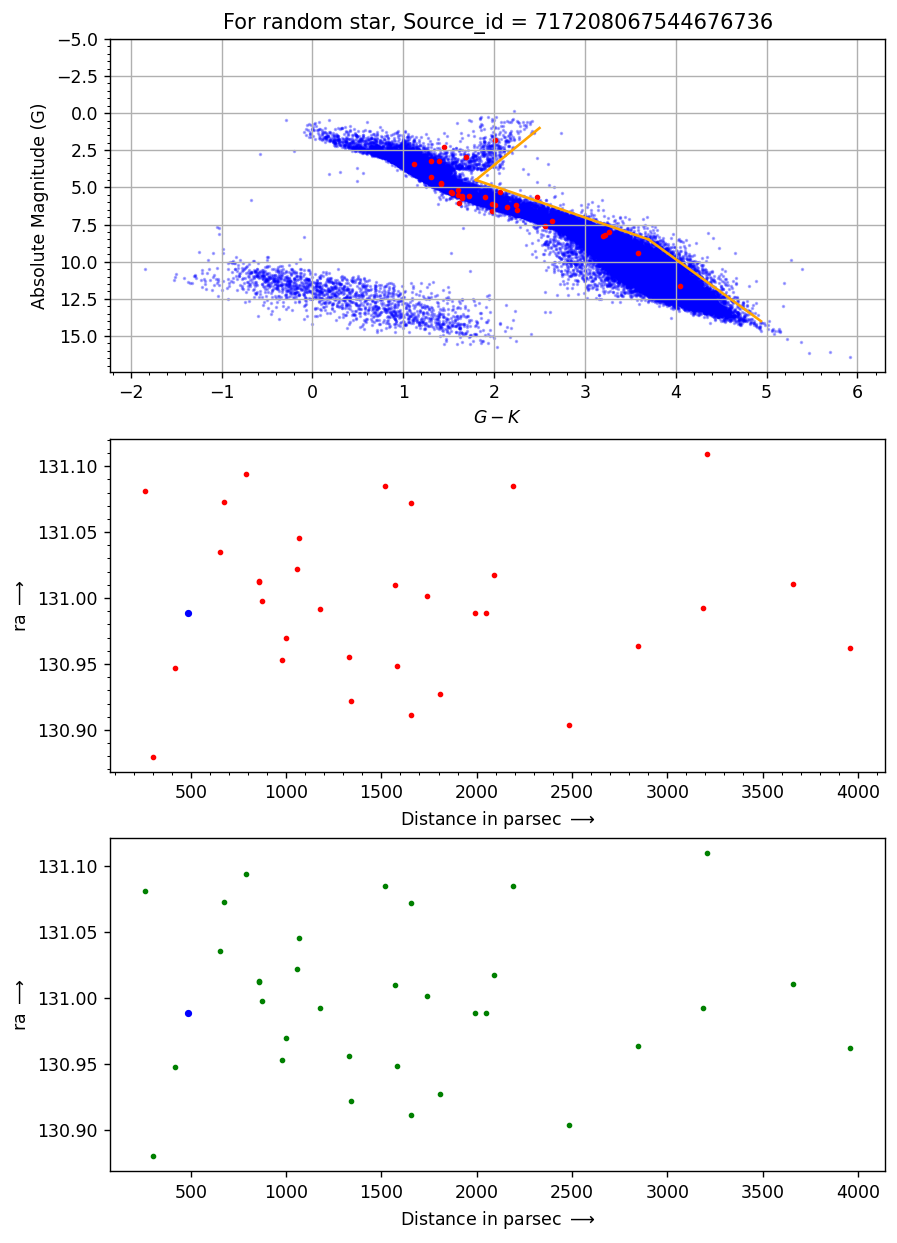

In [19]:
count_plot(rnd_star20["ra"][1], rnd_star20["dec"][1], rnd_star20["r_med_photogeo"][1], rnd_star20["source_id"][1])

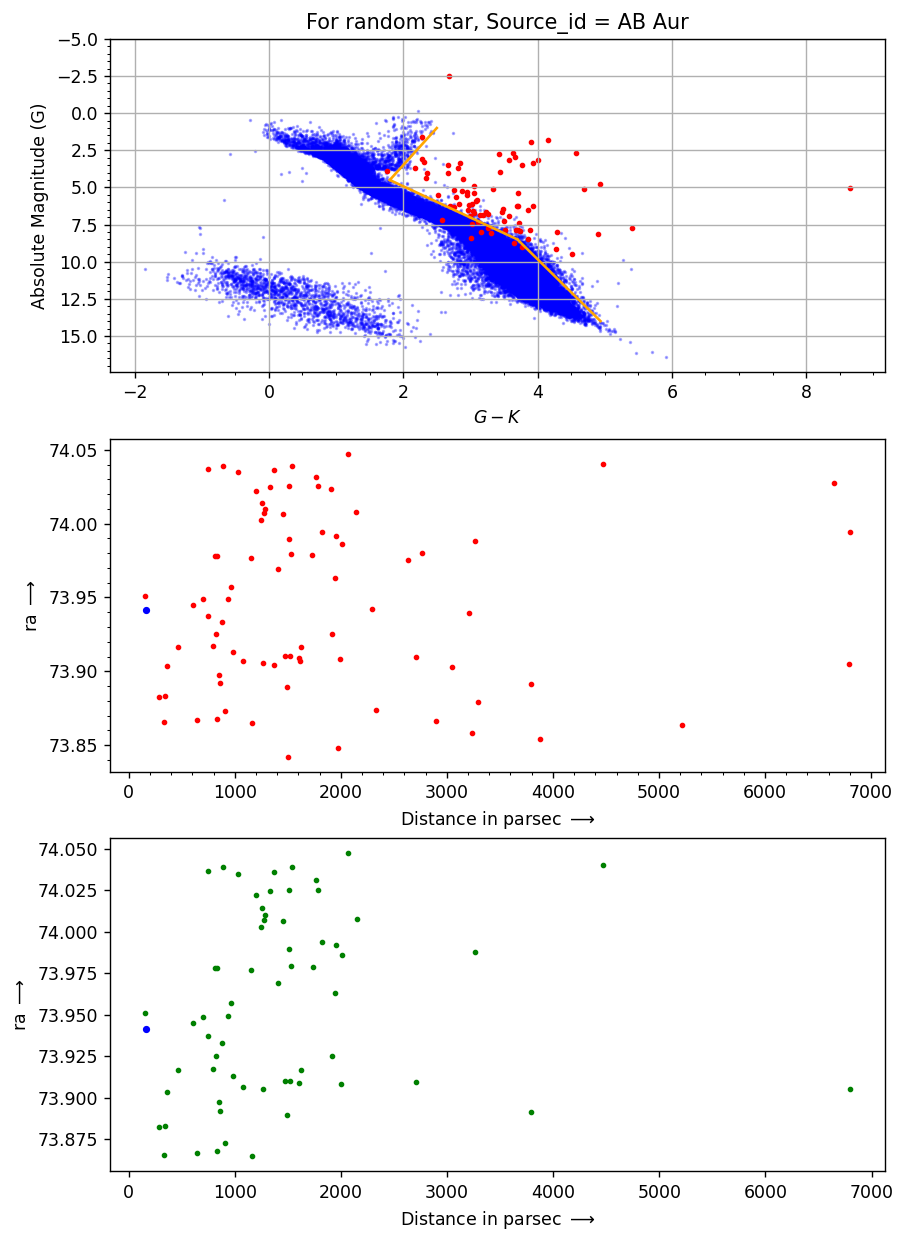

In [20]:
count_plot(herbig_20["RAICRS"][1], herbig_20["DEICRS"][1], herbig_20["Dist"][1], herbig_20["Name"][1])

In [21]:
print(rad_her, rad_star)
print(herbig_20["Dist"][1], rnd_star20["r_med_photogeo"][1])

6.118811881188119 1.8538906204533931
162.9 487.06802


### Defining a function for plotting the distance vs ra

In [22]:
# for i in range(20):

#     res_star = get_gaia_result(10000, rnd_star20["ra"][i], rnd_star20["dec"][i], 6.0/60.0)
#     res_her = get_gaia_result(10000, herbig_20["RAICRS"][i], herbig_20["DEICRS"][i], 6.0/60.0)


#     fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi = 125, figsize = (4,4))
#     ax1.scatter(res_star["r_med_photogeo"], res_star["ra"], c = 'red', s = 5)
#     ax1.scatter(rnd_star20["r_med_photogeo"][i], rnd_star20["ra"][i], c = 'blue', s = 10)
#     ax1.set_xlabel(r"Distance in parsec $\longrightarrow$")
#     ax1.set_ylabel(r"ra $\longrightarrow$")
#     ax1.set_title("For random star, Source_id = {}".format(rnd_star20["source_id"][i]))

#     ax2.scatter(res_her["r_med_photogeo"], res_her["ra"], c = 'red', s = 5)
#     ax2.scatter(herbig_20["Dist"][i], herbig_20["RAICRS"][i], c = 'blue', s = 10)
#     ax2.set_xlabel(r"Distance in parsec $\longrightarrow$")
#     ax2.set_ylabel(r"ra $\longrightarrow$")
#     ax2.set_title("For Herbig Ae/Be star, Name = {}".format(herbig_20["Name"][i]))

#     plt.subplots_adjust(hspace=0.4)
#     plt.show()

### Filtering out on the basis of parallax_error and fractional distance error

In [23]:
# for i in range(20):

    
#     res_star = get_gaia_result(10000, rnd_star20["ra"][i], rnd_star20["dec"][i], 6.0/60.0)
#     res_star = res_star[res_star["parallax_error"] < 0.3]
#     res_her = get_gaia_result(10000, herbig_20["RAICRS"][i], herbig_20["DEICRS"][i], 6.0/60.0)
#     res_her = res_her[res_her["parallax_error"] < 0.3]


#     fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi = 125, figsize = (8, 8))
#     ax1.scatter(res_star["r_med_photogeo"], res_star["ra"], c = 'red', s = 5)
#     ax1.scatter(rnd_star20["r_med_photogeo"][i], rnd_star20["ra"][i], c = 'blue', s = 10)
#     ax1.set_xlabel(r"Distance in parsec $\longrightarrow$")
#     ax1.set_ylabel(r"ra $\longrightarrow$")
#     ax1.set_title("For random star, Source_id = {}".format(rnd_star20["source_id"][i]))

#     ax2.scatter(res_her["r_med_photogeo"], res_her["ra"], c = 'red', s = 5)
#     ax2.scatter(herbig_20["Dist"][i], herbig_20["RAICRS"][i], c = 'blue', s = 10)
#     ax2.set_xlabel(r"Distance in parsec $\longrightarrow$")
#     ax2.set_ylabel(r"ra $\longrightarrow$")
#     ax2.set_title("For Herbig Ae/Be star, Name = {}".format(herbig_20["Name"][i]))

#     plt.subplots_adjust(hspace=0.4)
#     plt.show()

In [24]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star

    # After  distance filter

    after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    after_num_red_star_her = []   # For red object around Herbig Ae/Be star
    after_num_tot_star_rand = []  # For toatal star around random star
    after_num_red_star_rand = []  # For red objec around the Random Star
    


    for i in range(len(herbig_20.RAICRS)):

        herbig_star = get_gaia_result(1000, herbig_20.loc[i][1], herbig_20.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        after_herbig = herbig_star[herbig_star["dist_frac"] < 0.2]
        her_mg_af = after_herbig["mv"]
        her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]
        



        rand_star = get_gaia_result(1000, rnd_star20.loc[i][1], rnd_star20.loc[i][2], radius)
        rand_star = rand_star[rand_star["parallax_error"] < 0.3]
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]


        after_star = rand_star[rand_star["dist_frac"] < 0.2]
        rand_mg_af = after_star["mv"]
        rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]





        # y_values1 = np.linspace(1, 4.5, 50)
        # y_values2 = np.linspace(4.5, 8.5, 100)
        # y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
        # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'orange')
        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)

        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)


        af_her_red = counting_fun(her_mg_af, her_gk_af)
        after_num_tot_star_her.append(len(her_mg_af))
        after_num_red_star_her.append(af_her_red)


        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        af_star_red = counting_fun(rand_mg_af, rand_gk_af)
        after_num_tot_star_rand.append(len(rand_mg_af))
        after_num_red_star_rand.append(af_star_red)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
    
    


In [44]:
rad_arcmin = 6.0
all_list = list_red_object(rad_arcmin/60.0)

In [45]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]
af1 = all_list[4]
af2 = all_list[5]
af3 = all_list[6]
af4 = all_list[7]


In [46]:
print("\n")
print("-------------------------------   For Herbig Star    -----------------------------------")
print("\n")
print("Name of Herbig Star \t No of Red star    Total no of star    Fraction       After filter       No of red star        total no of star        Fraction")
print("-----------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:10s}\t". format(herbig_20.loc[i][0]) + "\t \t {:3d}".format(num_red_star_her[i]) + "\t \t{:3d}".format(num_tot_star_her[i]) + "\t \t \t{:0.4f}    |".format(num_red_star_her[i]/num_tot_star_her[i])
        + "\t \t {:3d}".format(af1[i]) + "\t \t{:3d}".format(af2[i]) + "\t \t \t{:0.4f}".format(af1[i]/af2[i]))

print("\n")
print(" Average number of red objects around a Herbig Star = {}".format(np.average(num_red_star_her)) + " within radius {}".format(rad_arcmin) + "      after distance filter, Avg number = {}".format(np.average(af1)) )


print(" ")


print("-----------------------------------------------------------------------------------------")
print("\n")
print("--------------------------------  For Random Star    ------------------------------------")
print("\n")
print("Sl. No. of Random Star \t No of Red star    Total no of star     Fraction        After filter        No of red star        total no of star        Fraction")
print("------------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:2d}\t".format(i+1) + "\t \t {}\t".format(num_red_star_rand[i]) + "\t \t{}".format(num_tot_star_rand[i]) + "\t \t \t{:0.4f}  |".format(num_red_star_rand[i]/num_tot_star_rand[i])
    + "\t \t {:3d}".format(af3[i]) + "\t \t{:3d}".format(af4[i]) + "\t \t \t{:0.4f}".format(af3[i]/af4[i]))


print("\n")

print(" Average number of red objects around a Random Star = {}".format(np.average(num_red_star_rand))+ " within radius {} arcminute".format(rad_arcmin) + "        after distance filter, Avg number = {}".format(np.average(af3)) )




-------------------------------   For Herbig Star    -----------------------------------


Name of Herbig Star 	 No of Red star    Total no of star    Fraction       After filter       No of red star        total no of star        Fraction
-----------------------------------------------------------------------------------------
 AK Sco    		 	 369	 	385	 	 	0.9584    |	 	 216	 	232	 	 	0.9310
 AB Aur    		 	  69	 	 81	 	 	0.8519    |	 	  52	 	 63	 	 	0.8254
 CQ Tau    		 	 162	 	218	 	 	0.7431    |	 	  96	 	145	 	 	0.6621
 BD+30 549 		 	  16	 	 19	 	 	0.8421    |	 	  15	 	 18	 	 	0.8333
 BH Cep    		 	 140	 	234	 	 	0.5983    |	 	 116	 	202	 	 	0.5743
 BO Cep    		 	 137	 	220	 	 	0.6227    |	 	 117	 	196	 	 	0.5969
 GSC 8143-1225		 	 119	 	269	 	 	0.4424    |	 	  98	 	232	 	 	0.4224
 BF Ori    		 	  14	 	 21	 	 	0.6667    |	 	  12	 	 19	 	 	0.6316
 CO Ori    		 	  77	 	114	 	 	0.6754    |	 	  60	 	 95	 	 	0.6316
 GSC 8581-2002		 	 190	 	258	 	 	0.7364    |	 	 162	 	226	 	 	0.7168
 A

In [47]:
# Creating list for storing the fractional values of red star after and before the distance filter

frac_before_herb = []
frac_before_rand = []
frac_after_herb = []
frac_after_rand = []

for i in range(20):
    f1 = num_red_star_her[i]/num_tot_star_her[i]
    f2 = num_red_star_rand[i]/num_tot_star_rand[i]
    frac_before_herb.append(f1)
    frac_before_rand.append(f2)


    f1 = af1[i]/af2[i]
    f2 = af3[i]/af4[i]
    frac_after_herb.append(f1)
    frac_after_rand.append(f2)

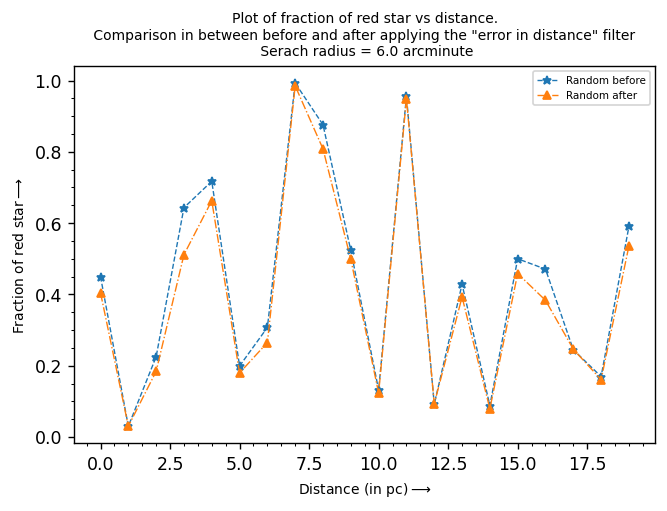

In [52]:
fig, ax = plt.subplots(dpi = 125)
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)

ax.plot(rnd_star20["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before")
ax.plot(rnd_star20["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after")


ax.plot(herbig_20["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before")
ax.plot(herbig_20["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after")


ax.legend(fontsize = 6)
# ax.set_xscale("log")
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()

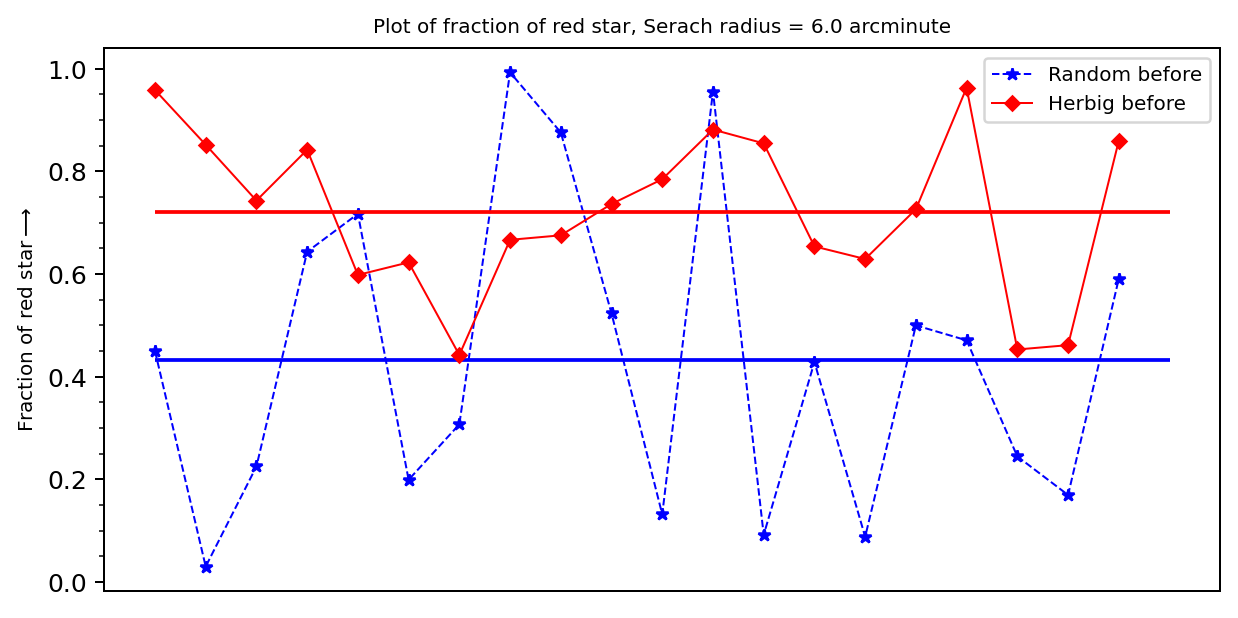

In [65]:
### MODIFIED DATE 26 Sep 2022


fig, ax = plt.subplots(figsize = [8, 4],dpi = 180)
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)

ax.plot(range(20), frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before", color = 'blue')
# ax.plot(range(20), frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after")
ax.hlines(np.average(frac_before_rand), 0, 20, color = 'blue')

ax.plot(range(20), frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", color = 'red')
# ax.plot(range(20), frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after")
ax.hlines(np.average(frac_before_herb), 0, 20, color = 'red')
plt.gca().axes.get_xaxis().set_visible(False)
ax.legend(fontsize = 8)
# ax.set_xscale("log")
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star, Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()

### MODIFIED DATE 26 Sep 2022

In [64]:
rnd_star20

,source_id,ra,dec,parallax,parallax_error,phot_g_mean_mag,r_med_geo,r_med_photogeo
0,4200915277519116928,289.349216,-9.702235,2.474588,0.247459,18.542698,401.68665,427.10970
1,717208067544676736,130.988664,34.529991,2.198941,0.219894,17.969261,477.89066,487.06802
2,4082907546369920128,289.018242,-20.506235,1.025029,0.102503,16.242178,959.35680,946.50010
3,3115770487149358336,104.615488,2.601685,0.841241,0.084124,16.782425,1087.39450,1049.19200
4,6064263444233418624,205.970705,-56.124049,0.689494,0.068949,16.481983,1274.97550,1302.96060
5,5786818418133769600,218.438884,-76.535295,0.709305,0.070930,17.090054,1283.99340,1333.41200
6,2072876119015206272,296.086160,37.976531,0.662385,0.066239,17.032260,1444.49790,1430.29960
7,5880671802993674496,222.109197,-58.008760,0.729744,0.072974,16.984085,1461.18700,1445.18410
8,6053305195978753408,184.533565,-64.331466,0.663882,0.066388,16.908943,1486.67410,1574.93690
9,5927385585287154944,251.762500,-58.115117,0.617804,0.061780,16.161259,1629.06820,1616.18260


In [49]:
search_radius = np.arange(2, 10.1, 2.0)/60
avg_star_her = []
avg_star_rand = []

af_avg_star_her = []
af_avg_star_rand = []


for i in range(len(search_radius)):

    all_list = list_red_object(search_radius[i])

    num_red_star_her = all_list[0]
    num_red_star_rand = all_list[2]
    af1 = all_list[4]
    af2 = all_list[6]
    

    avg_her = np.average(num_red_star_her)
    avg_rand = np.average(num_red_star_rand)
    avg_star_her.append(avg_her)
    avg_star_rand.append(avg_rand)


    af_her = np.average(af1)
    af_rand = np.average(af2)
    af_avg_star_her.append(af_her)
    af_avg_star_rand.append(af_rand)





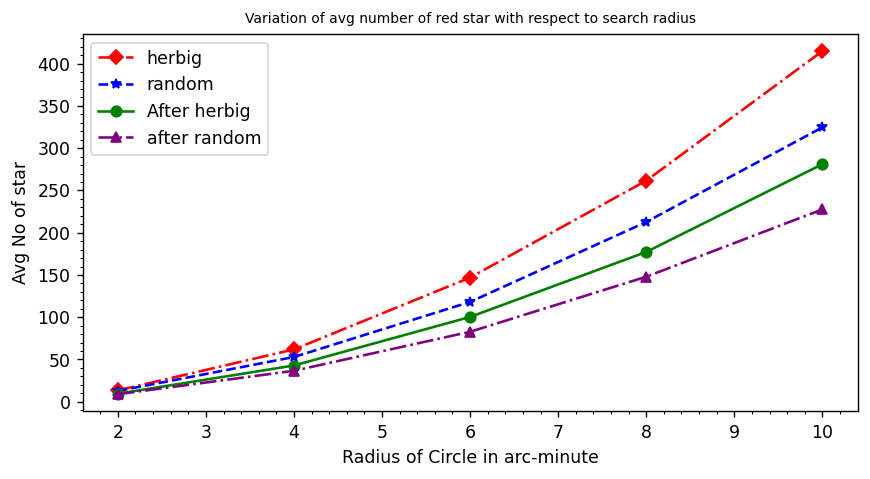

[13.4, 61.95, 146.9, 261.55, 414.85] [12.75, 52.95, 118.1, 212.65, 324.6]
After
[9.5, 42.9, 100.35, 177.2, 281.05] [8.9, 36.65, 82.8, 147.9, 227.55]


In [50]:
radius = np.arange(2.0, 10.1, 2.0)

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (8, 4), dpi = 125)
ax.plot(radius, avg_star_her, c = 'red', linestyle = '-.', marker = 'D', label = "herbig")
ax.plot(radius, avg_star_rand, c = 'blue', linestyle = "--", marker = "*", label = "random")


ax.plot(radius, af_avg_star_her, c = 'green', linestyle = '-', marker = 'o', label = 'After herbig')
ax.plot(radius, af_avg_star_rand, c = '#800080', linestyle = '-.', marker = '^', label = 'after random')

ax.minorticks_on()
#ax.grid()
ax.set_title("Variation of avg number of red star with respect to search radius", fontsize = 8)
ax.set_xlabel("Radius of Circle in arc-minute")
ax.set_ylabel("Avg No of star")
ax.legend()
plt.show()

print(avg_star_her, avg_star_rand)
print("After")
print(af_avg_star_her, af_avg_star_rand)